<a href="https://colab.research.google.com/github/emmanuel-olateju/EmotiSpot/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d khan1803115/eeg-dataset-for-emotion-recognition
!mkdir -p datasets/khan1803115
!unzip eeg-dataset-for-emotion-recognition.zip -d datasets/khan1803115/
!rm eeg-dataset-for-emotion-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/khan1803115/eeg-dataset-for-emotion-recognition
License(s): Apache 2.0
 98% 177M/181M [00:03<00:00, 78.5MB/s]
100% 181M/181M [00:03<00:00, 54.7MB/s]
Archive:  eeg-dataset-for-emotion-recognition.zip
  inflating: datasets/khan1803115/Data/S01G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G4AllChannels.csv  
  inflating:

In [2]:
import os

import numpy as np
import pandas as pd
!pip install mne
import mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.0 MB/s eta 0:00:00


In [3]:
import joblib
# from google.colab import files

def save_artifact(artifact,name):
  joblib.dump(artifact,name)
  # files.download(name)


## Data Loading

In [4]:
khan_dataset_dir = "datasets/khan1803115/"
valence = pd.read_csv(khan_dataset_dir+"valence_normalize.csv")
arousal = pd.read_csv(khan_dataset_dir+"arousal_normalize.csv")
data = [pd.read_csv(khan_dataset_dir+"Data/"+file) for file in os.listdir(khan_dataset_dir+"Data/")]

channels = data[0].columns[:-2]
label_columns = data[0].columns[-2:]
fs = 128

In [5]:
eeg_data = np.array([data_[channels][:38000] for data_ in data])
valence_arousal_values = np.array([data_[label_columns].mean() for data_ in data])
eeg_data.shape, valence_arousal_values.shape

((100, 38000, 14), (100, 2))

In [6]:
# Make use of 1280 samples for an epoch with 0 samples overlapping between succesive epochs
epoch_starting_points = np.arange(0,38252,1280-0)[:-4]

eeg_epochs = []

for i in range(len(data)):
    epochs = []
    for epoch_starting_point in epoch_starting_points:
        epochs.append(eeg_data[i,epoch_starting_point:epoch_starting_point+1280,:])

    eeg_epochs.append(epochs)

eeg_epochs = np.array(eeg_epochs)

eeg_epochs.shape

(100, 26, 1280, 14)

In [7]:
epoch_targets = []

for i in range(len(data)):
  targets = [valence_arousal_values[i]]*26
  epoch_targets.append(targets)

epoch_targets = np.array(epoch_targets)

epoch_targets.shape

(100, 26, 2)

In [8]:
eeg_epochs = eeg_epochs.reshape(2600,1280,14)
epoch_targets = epoch_targets.reshape(2600,2)

eeg_epochs.shape, epoch_targets.shape

((2600, 1280, 14), (2600, 2))

In [9]:
# save_artifact(eeg_epochs,"EEG_DATA.np")

## Preprocessing

In [10]:
lowcut = 1
highcut = 45

filtered_eeg_epochs = np.empty((2600,1280,14))

for e,epoch in enumerate(eeg_epochs):
  filtered = mne.filter.filter_data(epoch.T,fs,lowcut,highcut,verbose=0)
  filtered_eeg_epochs[e,:,:] = filtered.T

filtered_eeg_epochs.shape

(2600, 1280, 14)

In [11]:
# save_artifact(filtered_eeg_epochs,"FILTERED_EEG_DATA.np")
# save_artifact(epoch_targets,"EEG_VALENCE_AROUSAL_TARGETS.np")

## Make Dataloader

In [12]:
import random

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

# Set the device
device_ = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device: {device_}")

# Set the device globally
# torch.set_default_device(device_)

Current Device: cpu


In [13]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

  def __init__(self, features, targets, transform=None, device__="cpu"):
    self.features = torch.tensor(features,device=device__)
    self.targets = torch.tensor(targets,device=device__)
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    feature = self.features[idx,::]
    target = self.targets[idx]
    if self.transform:
      feature = self.transform(feature)
    return feature, target

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

random.seed(120)
torch.manual_seed(120)

X, y = filtered_eeg_epochs, epoch_targets

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.20, random_state=100)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=100)

for i in range(len(X_train)):
  scaler = StandardScaler()
  X_train[i,::] = scaler.fit_transform(X_train[i,::])

for i in range(len(X_test)):
  scaler = StandardScaler()
  X_test[i,::] = scaler.fit_transform(X_test[i,::])

for i in range(len(X_val)):
  scaler = StandardScaler()
  X_val[i,::] = scaler.fit_transform(X_val[i,::])

feature_scaler = MinMaxScaler()
y_train = feature_scaler.fit_transform(y_train)
y_test = feature_scaler.transform(y_test)
y_val = feature_scaler.transform(y_val)

print(f" Train Size :({X_train.shape}, {y_train.shape}) | Test Size : ({X_test.shape}, {y_test.shape}) | Validation Size: ({X_val.shape}, {y_val.shape})")

train_batch_size = 102
shuffle_ = True
num_workers_ = 5

# Make Train Dataloader
train_dataset = CustomDataset(X_train.astype(float),y_train.astype(float))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=shuffle_, num_workers=num_workers_)

# Make Validation Dataloader
val_batch_size = 34
val_dataset = CustomDataset(X_val.astype(float),y_val.astype(float))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=shuffle_, num_workers=num_workers_)

X_train = torch.tensor(X_train).to(torch.float)
y_train = torch.tensor(y_train).to(torch.float)
X_train = X_train.to(device_)
y_train = y_train.to(device_)

X_test = torch.tensor(X_test).to(torch.float)
y_test = torch.tensor(y_test).to(torch.float)
X_test = X_test.to(device_)
y_test = y_test.to(device_)

X_val = torch.tensor(X_val).to(torch.float)
y_val = torch.tensor(y_val).to(torch.float)
X_val = X_val.to(device_)
y_val = y_val.to(device_)

 Train Size :((2080, 1280, 14), (2080, 2)) | Test Size : ((260, 1280, 14), (260, 2)) | Validation Size: ((260, 1280, 14), (260, 2))


## Modelling

In [58]:
class mlp(nn.Module):

  def __init__(self):
    super(mlp,self).__init__()

    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1280*14,1000),
        nn.Sigmoid(),
        nn.Dropout(0.5),
        nn.Linear(1000,1000),
        nn.Sigmoid(),
        nn.Linear(1000,100),
        nn.Sigmoid(),
        nn.Linear(100,2),
        nn.Sigmoid(),
        nn.Linear(2,2),
        nn.ReLU()
    )


  def forward(self,x):

    x = x.view(x.size()[0],-1)
    x = self.fc1(x.to(torch.float32))

    return x

class cnn(nn.Module):

  def __init__(self):
    super(cnn,self).__init__()

    self.conv = nn.Sequential(
      nn.Dropout(0.1),
      nn.BatchNorm1d(14),
      nn.Conv1d(14,14,kernel_size=64,stride=32,padding=0), # OUTPUT: C=14, L=39
      nn.Tanh(),
      nn.AvgPool1d(kernel_size=3,stride=2), # OUTPUT: C=14, L=19
      # nn.Dropout(0.05),
      # nn.Conv1d(14,14,kernel_size=2,stride=1,padding=0), #OUTPUT: C=14, L=18
      # nn.ReLU(),
      # nn.AvgPool1d(kernel_size=5,stride=1), # OUTPUT: C=14, L=14
    )

    self.fc = nn.Sequential(
        nn.Linear(14*19,98),
        nn.Tanh(),
        nn.Linear(98,2),
        nn.LeakyReLU()
    )

  def forward(self,x):
    x = torch.transpose(x,1,2)
    x = self.conv(x)
    x = x.view(x.size()[0],-1)
    x = self.fc(x)

    return x


In [59]:
# torch.backends.cuda.cufft_plan_cache[0].max_size = 0

  0%|          | 0/100 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  1%|          | 1/100 [00:00<01:29,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 0/100 | loss: 0.18 |  validation loss: 0.12 | learning rate: [0.001]


  2%|▏         | 2/100 [00:01<01:23,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 1/100 | loss: 0.10 |  validation loss: 0.11 | learning rate: [0.001]


  3%|▎         | 3/100 [00:02<01:25,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 2/100 | loss: 0.10 |  validation loss: 0.10 | learning rate: [0.001]


  4%|▍         | 4/100 [00:03<01:26,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 3/100 | loss: 0.09 |  validation loss: 0.09 | learning rate: [0.001]


  5%|▌         | 5/100 [00:04<01:24,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 4/100 | loss: 0.09 |  validation loss: 0.09 | learning rate: [0.001]


  6%|▌         | 6/100 [00:05<01:23,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 5/100 | loss: 0.08 |  validation loss: 0.09 | learning rate: [0.001]


  7%|▋         | 7/100 [00:06<01:21,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 6/100 | loss: 0.08 |  validation loss: 0.08 | learning rate: [0.001]


  8%|▊         | 8/100 [00:07<01:22,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 7/100 | loss: 0.08 |  validation loss: 0.09 | learning rate: [0.001]


  9%|▉         | 9/100 [00:08<01:24,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 8/100 | loss: 0.08 |  validation loss: 0.08 | learning rate: [0.001]


 10%|█         | 10/100 [00:08<01:20,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 9/100 | loss: 0.08 |  validation loss: 0.08 | learning rate: [0.001]


 11%|█         | 11/100 [00:09<01:20,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 10/100 | loss: 0.08 |  validation loss: 0.08 | learning rate: [0.001]


 12%|█▏        | 12/100 [00:10<01:17,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 11/100 | loss: 0.07 |  validation loss: 0.08 | learning rate: [0.001]


 13%|█▎        | 13/100 [00:11<01:14,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 12/100 | loss: 0.07 |  validation loss: 0.08 | learning rate: [0.001]


 14%|█▍        | 14/100 [00:12<01:14,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 13/100 | loss: 0.07 |  validation loss: 0.07 | learning rate: [0.001]


 15%|█▌        | 15/100 [00:13<01:14,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 14/100 | loss: 0.07 |  validation loss: 0.08 | learning rate: [0.001]


 16%|█▌        | 16/100 [00:14<01:14,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 15/100 | loss: 0.07 |  validation loss: 0.07 | learning rate: [0.001]


 17%|█▋        | 17/100 [00:15<01:12,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 16/100 | loss: 0.06 |  validation loss: 0.07 | learning rate: [0.001]


 18%|█▊        | 18/100 [00:15<01:13,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 17/100 | loss: 0.06 |  validation loss: 0.07 | learning rate: [0.001]


 19%|█▉        | 19/100 [00:16<01:10,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 18/100 | loss: 0.06 |  validation loss: 0.07 | learning rate: [0.001]


 20%|██        | 20/100 [00:17<01:08,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 19/100 | loss: 0.06 |  validation loss: 0.07 | learning rate: [0.001]


 21%|██        | 21/100 [00:18<01:08,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 20/100 | loss: 0.06 |  validation loss: 0.07 | learning rate: [0.001]


 22%|██▏       | 22/100 [00:19<01:07,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 21/100 | loss: 0.06 |  validation loss: 0.07 | learning rate: [0.001]


 23%|██▎       | 23/100 [00:20<01:08,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 22/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 24%|██▍       | 24/100 [00:21<01:04,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 23/100 | loss: 0.05 |  validation loss: 0.06 | learning rate: [0.001]


 25%|██▌       | 25/100 [00:22<01:05,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 24/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 26%|██▌       | 26/100 [00:22<01:04,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 25/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 27%|██▋       | 27/100 [00:23<01:04,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 26/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 28%|██▊       | 28/100 [00:24<01:02,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 27/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 29%|██▉       | 29/100 [00:25<01:02,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 28/100 | loss: 0.05 |  validation loss: 0.06 | learning rate: [0.001]


 30%|███       | 30/100 [00:26<01:01,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 29/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 31%|███       | 31/100 [00:27<01:01,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 30/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 32%|███▏      | 32/100 [00:28<01:02,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 31/100 | loss: 0.05 |  validation loss: 0.06 | learning rate: [0.001]


 33%|███▎      | 33/100 [00:29<01:01,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 32/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.001]


 34%|███▍      | 34/100 [00:30<01:01,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 33/100 | loss: 0.05 |  validation loss: 0.06 | learning rate: [0.001]


 35%|███▌      | 35/100 [00:31<01:00,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 34/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 36%|███▌      | 36/100 [00:32<01:00,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 35/100 | loss: 0.05 |  validation loss: 0.07 | learning rate: [0.001]


 37%|███▋      | 37/100 [00:33<00:59,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 36/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.001]


 38%|███▊      | 38/100 [00:33<00:58,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 37/100 | loss: 0.05 |  validation loss: 0.06 | learning rate: [0.001]


 39%|███▉      | 39/100 [00:34<00:57,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 38/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.001]


 40%|████      | 40/100 [00:35<00:56,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 39/100 | loss: 0.04 |  validation loss: 0.07 | learning rate: [0.0001]


 41%|████      | 41/100 [00:36<00:55,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 40/100 | loss: 0.04 |  validation loss: 0.07 | learning rate: [0.0001]


 42%|████▏     | 42/100 [00:37<00:55,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 41/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 43%|████▎     | 43/100 [00:38<00:55,  1.02it/s]

----------------------------------------------------------------------------------
Epoch: 42/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 44%|████▍     | 44/100 [00:39<00:54,  1.02it/s]

----------------------------------------------------------------------------------
Epoch: 43/100 | loss: 0.05 |  validation loss: 0.06 | learning rate: [0.0001]


 45%|████▌     | 45/100 [00:40<00:52,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 44/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 46%|████▌     | 46/100 [00:41<00:51,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 45/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 47%|████▋     | 47/100 [00:42<00:51,  1.02it/s]

----------------------------------------------------------------------------------
Epoch: 46/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 48%|████▊     | 48/100 [00:43<00:50,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 47/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 49%|████▉     | 49/100 [00:44<00:49,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 48/100 | loss: 0.05 |  validation loss: 0.06 | learning rate: [0.0001]


 50%|█████     | 50/100 [00:45<00:47,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 49/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 51%|█████     | 51/100 [00:46<00:46,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 50/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 52%|█████▏    | 52/100 [00:47<00:44,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 51/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 53%|█████▎    | 53/100 [00:48<00:45,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 52/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 54%|█████▍    | 54/100 [00:49<00:44,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 53/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 55%|█████▌    | 55/100 [00:50<00:42,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 54/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 56%|█████▌    | 56/100 [00:51<00:40,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 55/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [0.0001]


 57%|█████▋    | 57/100 [00:52<00:41,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 56/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1e-05]


 58%|█████▊    | 58/100 [00:53<00:39,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 57/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1e-05]


 59%|█████▉    | 59/100 [00:54<00:39,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 58/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1e-05]


 60%|██████    | 60/100 [00:55<00:38,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 59/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1e-05]


 61%|██████    | 61/100 [00:56<00:38,  1.01it/s]

----------------------------------------------------------------------------------
Epoch: 60/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1e-05]


 62%|██████▏   | 62/100 [00:57<00:37,  1.02it/s]

----------------------------------------------------------------------------------
Epoch: 61/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1e-05]


 63%|██████▎   | 63/100 [00:58<00:36,  1.01it/s]

----------------------------------------------------------------------------------
Epoch: 62/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-06]


 64%|██████▍   | 64/100 [00:59<00:35,  1.02it/s]

----------------------------------------------------------------------------------
Epoch: 63/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-06]


 65%|██████▌   | 65/100 [00:59<00:34,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 64/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-06]


 66%|██████▌   | 66/100 [01:00<00:32,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 65/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-06]


 67%|██████▋   | 67/100 [01:01<00:30,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 66/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-06]


 68%|██████▊   | 68/100 [01:02<00:30,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 67/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-06]


 69%|██████▉   | 69/100 [01:03<00:29,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 68/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-07]


 70%|███████   | 70/100 [01:04<00:28,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 69/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-07]


 71%|███████   | 71/100 [01:05<00:27,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 70/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-07]


 72%|███████▏  | 72/100 [01:06<00:25,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 71/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-07]


 73%|███████▎  | 73/100 [01:07<00:25,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 72/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-07]


 74%|███████▍  | 74/100 [01:08<00:24,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 73/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000002e-07]


 75%|███████▌  | 75/100 [01:09<00:23,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 74/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 76/100 [01:10<00:22,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 75/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 77/100 [01:11<00:22,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 76/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 78/100 [01:12<00:20,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 77/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 79/100 [01:13<00:19,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 78/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 80/100 [01:14<00:19,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 79/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 81/100 [01:15<00:17,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 80/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 82/100 [01:15<00:16,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 81/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 83/100 [01:17<00:16,  1.02it/s]

----------------------------------------------------------------------------------
Epoch: 82/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 84/100 [01:17<00:15,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 83/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 85/100 [01:18<00:14,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 84/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 86/100 [01:19<00:12,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 85/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 87/100 [01:20<00:12,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 86/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 88/100 [01:21<00:11,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 87/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 89/100 [01:22<00:10,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 88/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 90/100 [01:23<00:09,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 89/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 91/100 [01:24<00:08,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 90/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 92/100 [01:25<00:07,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 91/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 93/100 [01:26<00:07,  1.00s/it]

----------------------------------------------------------------------------------
Epoch: 92/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 94/100 [01:27<00:05,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 93/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 95/100 [01:28<00:04,  1.01it/s]

----------------------------------------------------------------------------------
Epoch: 94/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 96/100 [01:29<00:04,  1.01s/it]

----------------------------------------------------------------------------------
Epoch: 95/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 97/100 [01:30<00:03,  1.02s/it]

----------------------------------------------------------------------------------
Epoch: 96/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 98/100 [01:31<00:02,  1.04s/it]

----------------------------------------------------------------------------------
Epoch: 97/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 99/100 [01:32<00:01,  1.05s/it]

----------------------------------------------------------------------------------
Epoch: 98/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]


100%|██████████| 100/100 [01:33<00:00,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 99/100 | loss: 0.04 |  validation loss: 0.06 | learning rate: [1.0000000000000004e-08]
------------------------------------------------------------------------------------
Test Loss: 0.22
------------------------------------------------------------------------------------
Loss
 


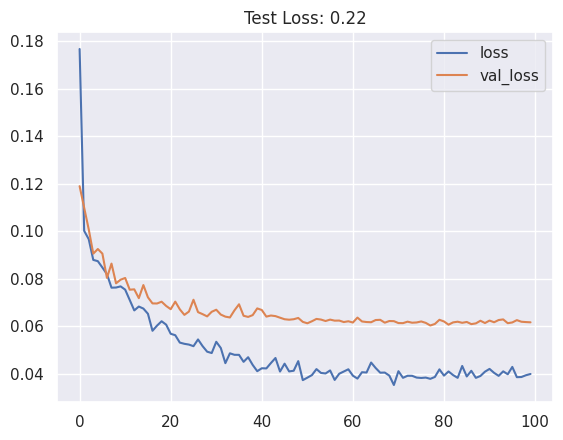

In [60]:
from tqdm import tqdm

history = {
    "loss":[],
    "val_loss":[]
}

model = cnn()
model = model.to(device_)

epochs = 100
lr_ = 0.001

optimizer = optim.Adam(model.parameters(),lr=lr_)
learning_rate = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.1, patience=5)
loss_fn = nn.MSELoss()

train_loss, val_loss = [], []

for e in tqdm(range(epochs)):

  running_loss = 0.0
  val_running_loss = 0.0
  steps = 0

  for i in range(5):

    indices = torch.randperm(X_train.size()[0])[:train_batch_size]

    x_ = X_train[indices,::].to(torch.float)
    x_ = abs(torch.fft.fft2(x_))
    y_ = y_train[indices,::].to(torch.float)

    x_ = x_.to(device_)
    y_ = y_.to(device_)

    model =model.train()

    optimizer.zero_grad()

    y_est = model(x_)
    y_est = y_est.requires_grad_(True)

    loss = loss_fn(y_est,y_)
    running_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    steps += 1

    # if steps == 5:
    #   break

  running_loss /= steps
  history["loss"].append(running_loss)

  val_running_loss = 0.0
  steps = 0

  for batch, (x_val, y_val) in enumerate(val_dataloader):

    x_val = x_val.to(torch.float)
    x_val = abs(torch.fft.fft2(x_val))
    y_val = y_val.to(torch.float)

    x_val = x_val.to(device_)
    y_val = y_val.to(device_)

    model = model.eval()
    y_est = model(x_val)

    loss = loss_fn(y_est,y_val)
    val_running_loss += loss.item()

    steps += 1

    # if steps == 5:
    #   break


  val_running_loss /= steps
  history["val_loss"].append(val_running_loss)

  learning_rate.step(val_running_loss)
  last_lr = learning_rate.get_last_lr()

  print("----------------------------------------------------------------------------------")
  print(f"Epoch: {e}/{epochs} | loss: {running_loss:.2f} |  validation loss: {val_running_loss:.2f} | learning rate: {last_lr}")

model = model.eval()

y_ = model(X_test)
y_test = y_test.requires_grad_(True)

loss = loss_fn(y_test,y_)
print("------------------------------------------------------------------------------------")
print(f"Test Loss: {loss.item():.2f}")
print("------------------------------------------------------------------------------------")

print("Loss")
print(" ")
import matplotlib.pyplot as plt

plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="val_loss")

plt.title(f"Test Loss: {loss.item():.2f}")

plt.grid()
plt.legend()



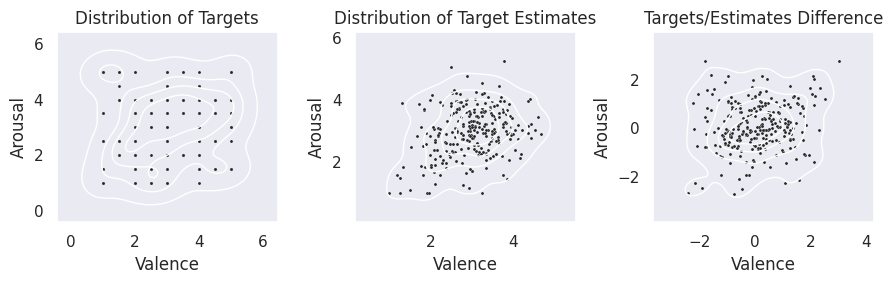

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

fig, ax_  = plt.subplots(1,3,figsize=(9,3))

# X_test = torch.tensor(X_test).to(float)
# y_test = torch.tensor(y_test).to(float)

y = feature_scaler.inverse_transform(y_test.detach().numpy())

sns.scatterplot(x=y[:,0], y=y[:,1], s=5, color=".15", ax=ax_[0])
# sns.histplot(x=y[:,0], y=y[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[0])
sns.kdeplot(x=y[:,0], y=y[:,1], levels=5, color="w", linewidths=1, ax=ax_[0])

model = model.eval()

y_est = model(abs(torch.fft.fft2(X_test)))
y_est = y_est.detach().numpy()
y_est = feature_scaler.inverse_transform(y_est)

sns.scatterplot(x=y_est[:,0], y=y_est[:,1], s=5, color=".15", ax=ax_[1])
# sns.histplot(x=y_est[:,0], y=y_est[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[1])
sns.kdeplot(x=y_est[:,0], y=y_est[:,1], levels=5, color="w", linewidths=1, ax=ax_[1])

from scipy.spatial.distance import cdist
distance = feature_scaler.inverse_transform(y_test.detach().numpy())-y_est
sns.scatterplot(x=distance[:,0], y=distance[:,1], s=5, color=".15", ax=ax_[2])
# sns.histplot(x=distance[:,0], y=distance[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[2])
sns.kdeplot(x=distance[:,0], y=distance[:,1], levels=5, color="w", linewidths=1, ax=ax_[2])

ax_[0].set_title("Distribution of Targets")
ax_[0].set_xlabel("Valence")
ax_[0].set_ylabel("Arousal")

ax_[1].set_title("Distribution of Target Estimates")
ax_[1].set_xlabel("Valence")
ax_[1].set_ylabel("Arousal")

ax_[2].set_title("Targets/Estimates Difference")
ax_[2].set_xlabel("Valence")
ax_[2].set_ylabel("Arousal")

fig.tight_layout()

In [62]:
def checkpoint_model(model,name,test_performance):
  model_ = {
      "model":model,
      "model_weights":model.state_dict(),
      "performance":test_performance
  }
  joblib.dump(model_,name)

In [63]:
checkpoint_model(model=model,name="cnn_9.sav",test_performance="0.22 Test MSE Loss")